In [1]:
from Model_GPR import Model,GPR,gamma,normal,RBF_2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, cm
import pandas as pd
import numpy as np

## This notebooks shows an universal Kriging example with the Hamiltonian Monte Carlo method

It is has the following sections,

1. Generating the data
2. Defining and prior checking a initial model
3. Enhance the inital model 
4. Optimizing the model parameter by applying the HMC method
5. Calculating the posterior predictive mean for new inputs

## 1. Generating the data

We randomly generate some two dimensional input $X_{obs}$ and define some "unknown mean" function, so that there is some trend in the observations $Y_{obs}$.
We choose a quadratic polynomial and assume that the observations are dissorted by some normally distributed noise 

$$Y_{obs}=aX_{1}^{2}+bX_{2}^{2}+ \epsilon$$,
with $a=0.4,b=0.3$ and $\epsilon \sim N(0,1)$.

In [2]:
def unknown_mean(X,a,b):
    return a*X[:,0]**2-b*X[:,1]**2

np.random.seed(404) 
noise = 1.0
x, y = np.arange(-5, 5, 0.3), np.arange(-5, 5, 0.3)
xx, yy = np.meshgrid(x, y)
X_2D = np.column_stack((xx.reshape(-1),yy.reshape(-1)))
X_obs = np.random.uniform(-4, 4, (100, 2))
Y_obs = unknown_mean(X_obs,0.4,-0.3) +  noise * np.random.randn(len(X_obs))

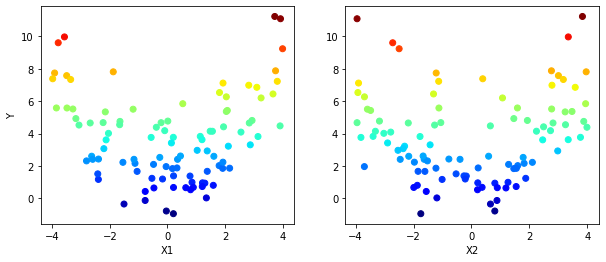

In [3]:
fig_1 ,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
ax1.scatter(X_obs[:,0],Y_obs, c=Y_obs, cmap=cm.jet)
ax1.set_xlabel('X1')
ax1.set_ylabel('Y')
ax2.scatter(X_obs[:,1],Y_obs,c=Y_obs,cmap=cm.jet)
ax2.set_xlabel('X2');

## 2) Defining the initial model and computing prior predictive checks

## We start with MAP estimation with the numpy+scipy approach 

We define a custom mean function, which is quadratic in each dimension, which is a guess from the observations.

In [4]:
class custom_mean:
    def __init__(self,a,b):
        self.a = a
        self.b = b
    def evaluate(self,X,grad=False):
        if grad:
            return [X[:,0],X[:,1]]
        return self.a*X[:,0]**2 + self.b*X[:,1]**2

## Defining the model

For our first model we use the following prior assumptions

\begin{align*}
     \ell &\sim \Gamma(2.0,3.0)  \\
    \sigma  &\sim \Gamma(2.0,3.0)  \\
    \sigma\_{\text{noise}}&\sim \Gamma(3.0,1.0)\\
    a &\sim N(0,1)  \\
    b &\sim N(0,1)  
\end{align*}

which is just a guess.

In [5]:
test_model = GPR("Test_1")
with test_model as model_2:
    model_2.add_prior("ℓ",gamma(2,3))
    model_2.add_prior("σ",gamma(2,3))
    model_2.add_prior("noise", gamma(3,1))
    model_2.add_cov(RBF_2)
    model_2.add_mean(custom_mean)
    model_2.add_prior("a",normal(0,1))
    model_2.add_prior("b",normal(0,1))
    model_2.summarize()
    res = model_2.MAP(X_obs,Y_obs,theta=[1, 1,0.3,1.0,1.0])
print(res)

model:Test_1
 self.prior :{'ℓ': <Model_GPR.gamma object at 0x00000190299038D0>, 'σ': <Model_GPR.gamma object at 0x0000019029903E10>, 'noise': <Model_GPR.gamma object at 0x0000019029903E48>, 'a': <Model_GPR.normal object at 0x0000019029903EB8>, 'b': <Model_GPR.normal object at 0x0000019029903F60>}
      fun: 140.6237275624158
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 8.52651283e-06,  2.84217094e-06,  1.42108547e-05, -3.97903932e-05,
       -8.52651283e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 216
      nit: 30
   status: 0
  success: True
        x: array([0.38081712, 0.26558036, 0.92213949, 0.40698305, 0.31597265])


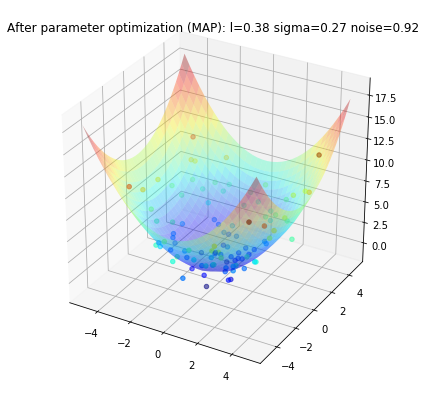

In [6]:
model_2.posterior_dist(X_2D,X_obs,Y_obs)
fig_2 = plt.figure(figsize=(7,7))
model_2.plot_post_dist(xx,yy,X_obs,Y_obs,"After parameter optimization (MAP): l={} sigma={} noise={}".format(np.round(res.x[0],2),np.round(res.x[1],2),np.round(res.x[2],2)))

## MAP estimation with pymc3

In [7]:
import pymc3 as pm
import theano
import theano.tensor as tt

We define a custom mean function for the quadratic polynomial since it not predefined by default.
Note that we need to use theano tensors.

In [8]:
class Custom(pm.gp.mean.Mean):

    def __init__(self, a=1.0,b=1.0):
        self.a = a
        self.b = b

    def __call__(self, X):
        return tt.alloc(1.0,X.shape[0])*self.a*X[:,0]**2 + tt.alloc(1.0,X.shape[0])*self.b*X[:,1]**2

## The initial model in the pymc3 syntax

In [9]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2.0, beta=3.0)
    σ = pm.Gamma("σ", alpha=2.0, beta=3.0)
    
    cov = σ ** 2 * pm.gp.cov.ExpQuad(2, ℓ)
    
    a = pm.Normal("a",mu=0.0,sd=1.0)
    b = pm.Normal("b", mu=0.0,sd=1.0)
    
    quadratic = Custom(a,b)
    gp = pm.gp.Marginal(mean_func=quadratic,cov_func=cov)

    σ_noise = pm.Gamma("σ_noise", alpha=3.0,beta=1.0)
    y_ = gp.marginal_likelihood("y", X=X_obs, y=Y_obs, noise=σ_noise)

    mp = pm.find_MAP(method='BFGS')

## Comparison of MAP estimation with numpy+scipy and pymc3

In [10]:
np.array([mp['ℓ'], mp['σ'], mp['σ_noise'],mp['a'],mp['b']])-model_2.theta

array([-8.53078482e-07,  2.34772651e-09, -9.81075963e-08,  1.35812636e-08,
       -1.33484128e-08])

In [11]:
mp

{'ℓ_log__': array(-0.96543826),
 'σ_log__': array(-1.32583782),
 'a': array(0.40698306),
 'b': array(0.31597265),
 'σ_noise_log__': array(-0.08105888),
 'ℓ': array(0.38081627),
 'σ': array(0.26558036),
 'σ_noise': array(0.9221394)}

## Prior predictive checks for the initial model

We compute the expected value for the observations given the parameter 

$$ E_{\theta}[X_{obs}|\theta]=\int_{\Theta}p(X_{obs}|\theta)p(\theta)\text{d}\theta $$

by randomly draw 500 samples of the parameters from their prior distribution $p(\theta)$ and then generate 100 samples of the posterior distribution given the parameter sample.
We then can compute the mean function of the inputs $X_{obs}$ with the sampled regression parameter and check if the mean function seems close to the trend we saw in the data.
Moreover we can average over the 100 samples from each sampled parameter to see if the expected value falls within the vinicity of the observations.

In [12]:
with model:
    prior_checks = pm.sample_prior_predictive(samples=500, random_seed=404)

In [13]:
print("sampled parameters have dimension 500x1\n p(a) ~ {}".format(prior_checks['a'].shape))

print("sampled observations have dimension 500x100 (we have 500 samples of the process for each prior draw)\n p(y|a_{}) ~ {}".format("i",prior_checks['y'].shape))


sampled parameters have dimension 500x1
 p(a) ~ (500,)
sampled observations have dimension 500x100 (we have 500 samples of the process for each prior draw)
 p(y|a_i) ~ (500, 100)


In [14]:
import arviz as az

C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


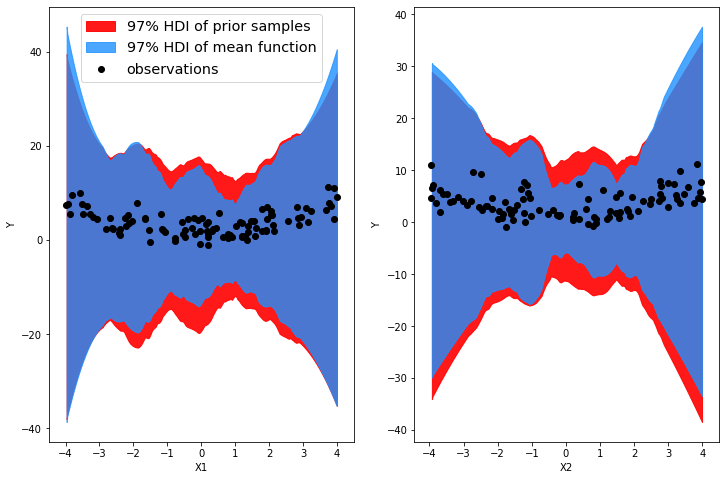

In [16]:
#compute the mean function for prior regression parameter
mu_pp = (prior_checks["a"]*X_obs[:,0][:,None]**2+prior_checks["b"]*X_obs[:,1][:,None]**2).T
_, ax1 = plt.subplots(1,2, figsize=(12,8))
az.plot_hpd(
    X_obs[:,0],
    prior_checks["y"],
    hdi_prob=0.97,
    ax=ax1[0],
    fill_kwargs={"alpha": 0.9, "label": "97% HDI of prior samples" ,"color":"red"},
)
az.plot_hpd(
    X_obs[:,0],
    mu_pp,
    hdi_prob=0.97,
    ax=ax1[0],
    fill_kwargs={"alpha": 0.8, "label": "97% HDI of mean function","color":"dodgerblue"},
)
ax1[0].scatter(X_obs[:,0],Y_obs, color="black", label="observations")
ax1[0].set_xlabel("X1")
ax1[0].set_ylabel("Y")
az.plot_hpd(
    X_obs[:,1],
    prior_checks["y"],
    hdi_prob=0.97,
    ax=ax1[1],
    fill_kwargs={"alpha": 0.9, "label": "Mean outcome 97% HPI" ,"color":"red"},
)
az.plot_hpd(
    X_obs[:,1],
    mu_pp,
    hdi_prob=0.97,
    ax=ax1[1],
    fill_kwargs={"alpha": 0.8, "label": "Mean outcome 97% HPD","color":"dodgerblue"},
)
ax1[1].set_xlabel("X2")
ax1[1].scatter(X_obs[:,1],Y_obs, color="black", label="observations");
ax1[1].set_ylabel("Y")
ax1[0].legend(fontsize="x-large")

In [18]:
_.savefig("Prior_predictive_check_model1.pdf")

## We can see that this was a poor prior definition

## 3) Enhance the model

We use the MAP estimation which we already have to define more informative priors.
For example could we define the regression priors less vague by changing the mean to the MAP estimation of a and b and scaling down the variance.
Moreover can we look at the MAP estimates of the remaining parameters and seek for some better parameter for their prior distributions. 
Lets look at the gamma priors and change the prior for the noise level to an Halfnormal distribution.

In [257]:
import math
gamma_dist = lambda x,a,b: b**a/math.gamma(a)*x**(a-1)*np.exp(-b*x)
half_normal = lambda x,sigma: (2/(np.pi*sigma**2))**0.5*np.exp(-x**2/(2*sigma**2))

E[p(noise_level)]=1.3564037533648714


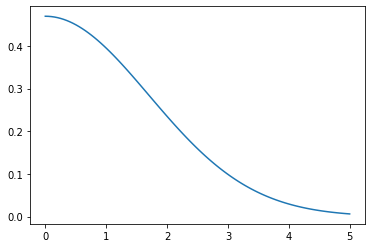

In [259]:
#prior for noise_level
x_prior = np.linspace(0,5,100)
s=1.7
plt.plot(x_prior,half_normal(x_prior,s))
print("E[p(noise_level)]={}".format(s*2**0.5/np.pi**0.5))

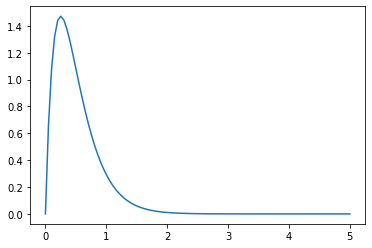

In [262]:
#prior for kernel parameters
plt.plot(x_prior,gamma_dist(x_prior,2.0,4.0));

## Second model with more informative priors

In [19]:
with pm.Model() as model_2:
    ℓ = pm.Gamma("ℓ", alpha=2.0, beta=4.0)
    
    σ = pm.Gamma("σ", alpha=2.0, beta=4.0)
    
    cov = σ ** 2 * pm.gp.cov.ExpQuad(2, ℓ)
    
    a = pm.Normal("a",mu=0.4,sd=0.1)
    b = pm.Normal("b", mu=0.3,sd=0.1)
    
    quadratic = Custom(a,b)
    gp = pm.gp.Marginal(mean_func=quadratic,cov_func=cov)

    σ_noise = pm.HalfNormal("σ_noise", sigma=1.7)
    y_ = gp.marginal_likelihood("y", X=X_obs, y=Y_obs, noise=σ_noise)
    
    prior_checks = pm.sample_prior_predictive(samples=500, random_seed=404)
    mp = pm.find_MAP(method='BFGS')

## Prior predictive checks for enhanced model

This time the trend of the prior predictive check seems similar to the real trend in the data, and the prior predictive samples fall in the vinicity of the observed data.

C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


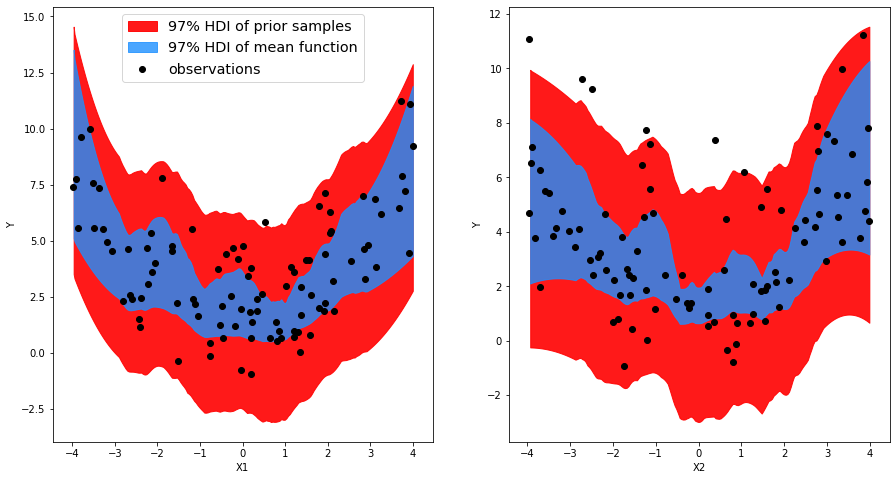

In [20]:
#plot prior checks
mu_pp = (prior_checks["a"]*X_obs[:,0][:,None]**2+prior_checks["b"]*X_obs[:,1][:,None]**2).T
_, ax1 = plt.subplots(1,2, figsize=(15,8))
az.plot_hpd(
    X_obs[:,0],
    prior_checks["y"],
    hdi_prob=0.97,
    ax=ax1[0],
    fill_kwargs={"alpha": 0.9, "label": "97% HDI of prior samples" ,"color":"red"},
)
az.plot_hpd(
    X_obs[:,0],
    mu_pp,
    hdi_prob=0.97,
    ax=ax1[0],
    fill_kwargs={"alpha": 0.8, "label": "97% HDI of mean function","color":"dodgerblue"},
)
ax1[0].scatter(X_obs[:,0],Y_obs, color="black", label="observations")
ax1[0].set_xlabel("X1")
ax1[0].set_ylabel("Y")
az.plot_hpd(
    X_obs[:,1],
    prior_checks["y"],
    hdi_prob=0.97,
    ax=ax1[1],
    fill_kwargs={"alpha": 0.9, "label": "Mean outcome 97% HPD" ,"color":"red"},
)
az.plot_hpd(
    X_obs[:,1],
    mu_pp,
    hdi_prob=0.97,
    ax=ax1[1],
    fill_kwargs={"alpha": 0.8, "label": "Mean outcome 97% HPD","color":"dodgerblue"},
)
ax1[1].scatter(X_obs[:,1],Y_obs, color="black", label="observations");
ax1[1].set_xlabel("X2")
ax1[1].set_ylabel("Y")
ax1[0].legend(fontsize="x-large")

In [21]:
_.savefig("Prior_predictive_check_model2.pdf")

## 4) Optimizing the model paramter with the HMC mehtod

In [22]:
with model_2:
    trace_hmc=pm.sample(draws=2000,step=pm.HamiltonianMC(is_cov=True,target_accept=0.95),chains=4, tune=2000,random_seed=404)

C:\ProgramData\Anaconda3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Multiprocess sampling (4 chains in 2 jobs)
HamiltonianMC: [σ_noise, b, a, σ, ℓ]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 231 seconds.


Summary of the run, we see that there were no divergences and the autocorrelation of the sampled values and the chains also looks fine.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.41,0.02,0.37,0.44,0.0,0.0,8156.90,8156.90,8149.22,5646.07,1.0
b,0.32,0.02,0.29,0.34,0.0,0.0,9608.88,9608.88,9639.67,5928.26,1.0
ℓ,0.43,0.32,0.01,0.99,0.0,0.0,8479.58,8359.81,5271.01,3804.36,1.0
σ,0.31,0.17,0.03,0.62,0.0,0.0,3054.50,2379.38,3294.44,1919.49,1.0
σ_noise,0.91,0.10,0.72,1.09,0.0,0.0,2666.02,2666.02,3840.23,1704.06,1.0


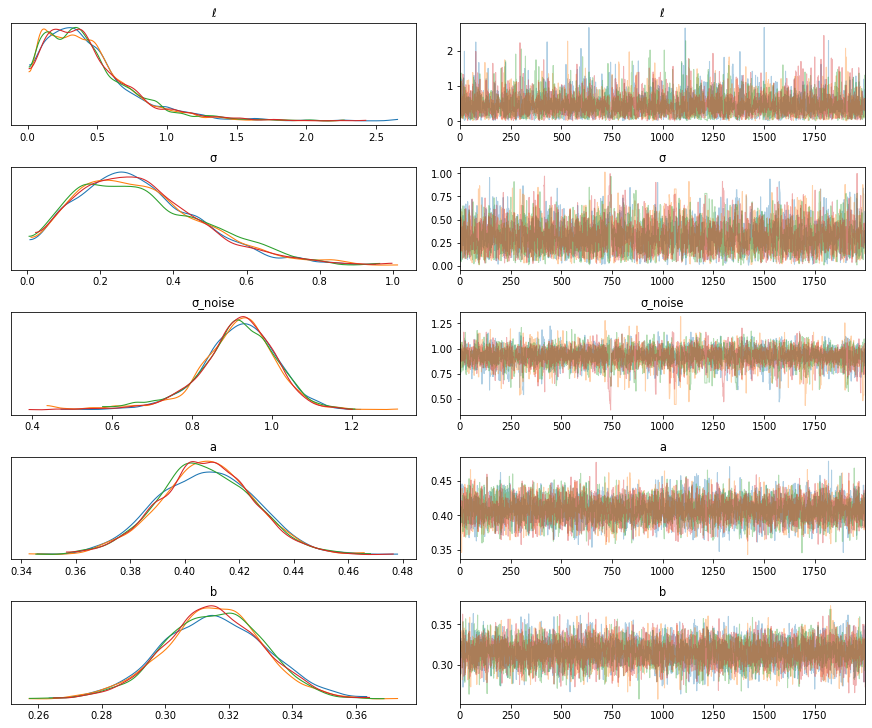

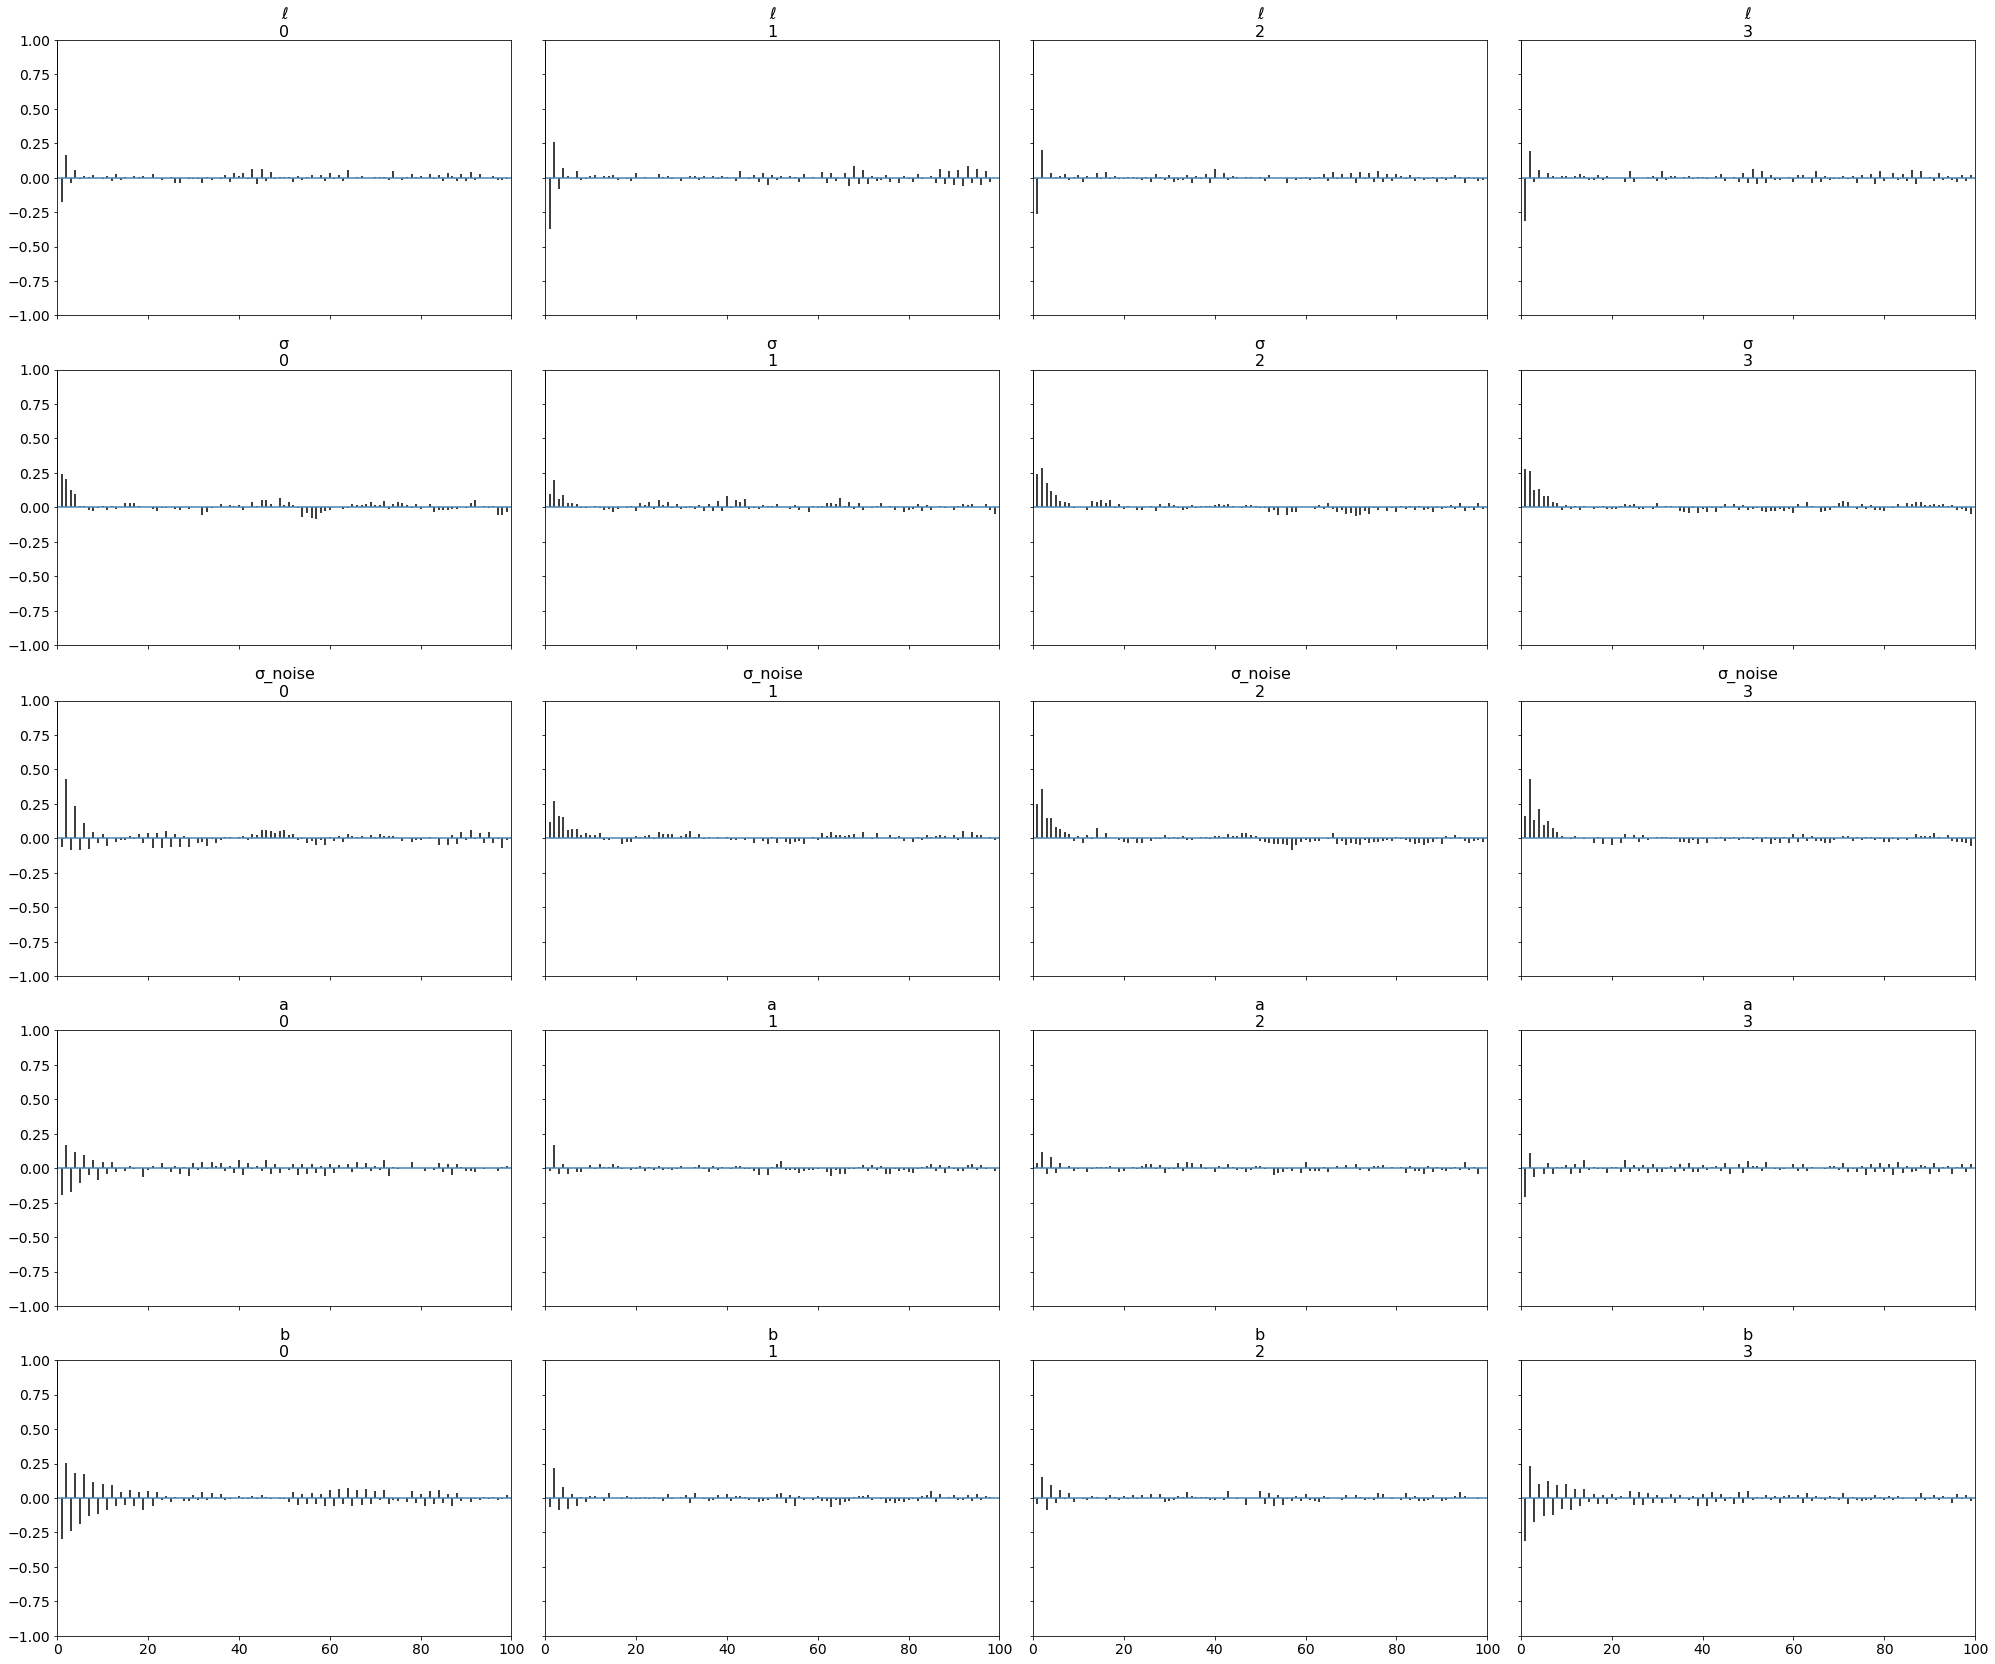

In [21]:
with model_2:
    az.plot_trace(trace_hmc, var_names=["ℓ", "σ", "σ_noise","a","b"]);
    display(az.summary(trace_hmc, round_to=2))
    az.plot_autocorr(trace_hmc, var_names=["ℓ", "σ", "σ_noise","a","b"])

## Posterior predictive checks

Similar to the concept of prior predictive checking, this time we randmoly draw 10000 sample parameters of the trace and generate 300 samples of the process given the sampled parameters.

In [23]:
with model_2:
    ppc = pm.sample_posterior_predictive(
        trace_hmc, var_names=["y","a","b","σ_noise","ℓ","σ"],samples=10000, random_seed = 404)

C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


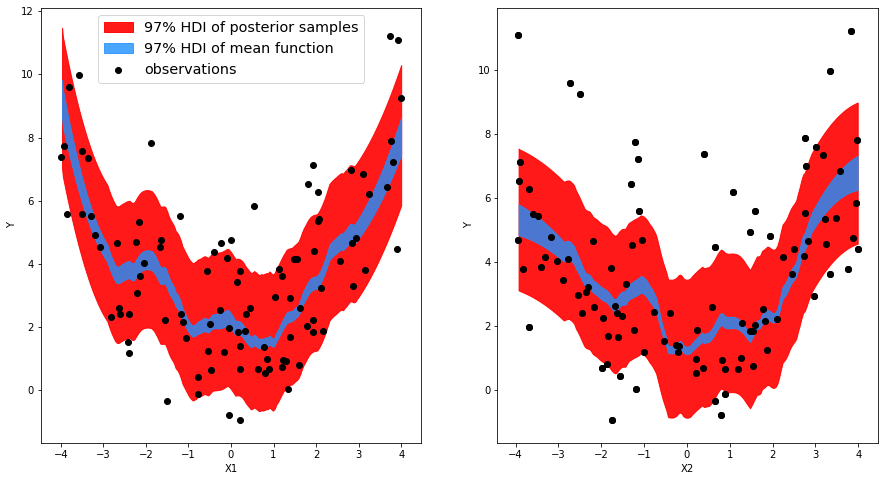

In [32]:
mu_pp = (ppc["a"]*X_obs[:,0][:,None]**2+ppc["b"]*X_obs[:,1][:,None]**2).T
fig_4, ax1 = plt.subplots(1,2, figsize=(15,8))
az.plot_hpd(
    X_obs[:,0],
    ppc["y"],
    hdi_prob=0.97,
    ax=ax1[0],
    fill_kwargs={"alpha": 0.9, "label": "97% HDI of posterior samples" ,"color":"red"},
)
az.plot_hpd(
    X_obs[:,0],
    mu_pp,
    hdi_prob=0.97,
    ax=ax1[0],
    fill_kwargs={"alpha": 0.8, "label": "97% HDI of mean function","color":"dodgerblue"},
)
ax1[0].scatter(X_obs[:,0],Y_obs, color="black", label="observations")
ax1[0].set_xlabel("X1")
ax1[0].set_ylabel("Y")
ax1[1].scatter(X_obs[:,1],Y_obs, color="black", label="observations");
az.plot_hpd(
    X_obs[:,1],
    ppc["y"],
    hdi_prob=0.97,
    ax=ax1[1],
    fill_kwargs={"alpha": 0.9, "label": "Mean outcome 97% HPD" ,"color":"red"},
)
az.plot_hpd(
    X_obs[:,1],
    mu_pp,
    hdi_prob=0.97,
    ax=ax1[1],
    fill_kwargs={"alpha": 0.8, "label": "Mean outcome 97% HPD","color":"dodgerblue"},
)
ax1[1].scatter(X_obs[:,1],Y_obs, color="black", label="observations");
ax1[1].set_xlabel("X2")
ax1[1].set_ylabel("Y")
ax1[0].legend(fontsize="x-large")

In [33]:
fig_4.savefig("posterior_predictive_check_model2.pdf")

## Calculating posterior predictive mean for new inputs

In [27]:
#generating unseen data
X_pred_1, X_pred_2 = np.random.uniform(-5, -3, (100, 2)),np.random.uniform(3, 5, (100, 2))
#mix unseend data and observation data
X_pred = np.row_stack((X_pred_1,X_pred_2,X_obs))

In [28]:
estimate_trace ={}
for i in trace_hmc.varnames:
    estimate_trace[i] = trace_hmc[i].mean()
#predictive sampling
with model_2:
    y_predictions = gp.conditional("y_predictions", X_pred,pred_noise=True)
    pred_samples = pm.sample_posterior_predictive([estimate_trace], vars=[y_predictions], samples=10000)

In [29]:
print("sampled observations have dimension 10000x300 (we have 100000 samples of the process for each posterior draw of theta given Y_obs)\n p(y,theta|Y_obs) ~ {}".format(pred_samples["y_predictions"].shape))

sampled observations have dimension 10000x300 (we have 100000 samples of the process for each posterior draw of theta given Y_obs)
 p(y,theta|Y_obs) ~ (10000, 300)


## Plotting posterior mean of new observations

C:\ProgramData\Anaconda3\lib\site-packages\arviz\stats\stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


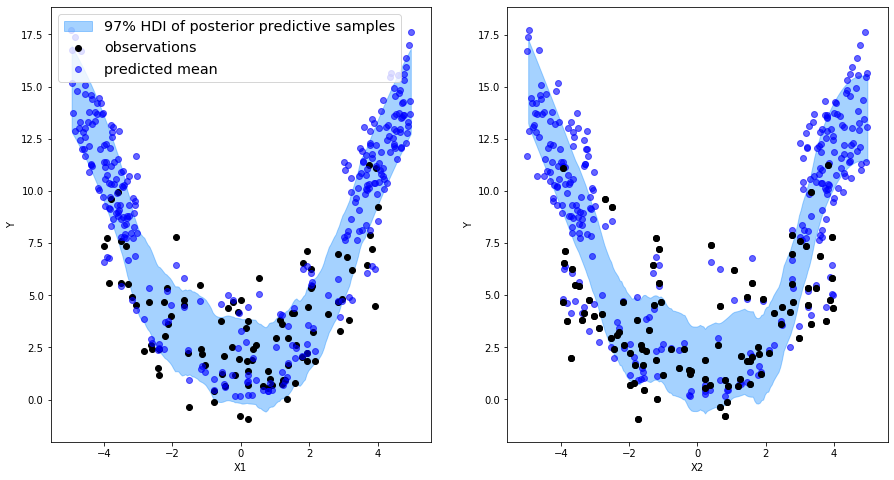

In [30]:
fig_4, ax1 = plt.subplots(1,2, figsize=(15,8))
az.plot_hpd(
    X_pred[:,0],
    pred_samples["y_predictions"],
    hdi_prob=0.97,
    ax=ax1[0],
    fill_kwargs={"alpha": 0.4, "label": "97% HDI of posterior predictive samples","color": "dodgerblue"},
)
ax1[0].scatter(X_obs[:,0],Y_obs, color="black", label="observations")
ax1[0].scatter(X_pred[:,0],pred_samples["y_predictions"].mean(0), color="blue", label="predicted mean",alpha=0.6)
ax1[0].set_xlabel("X1")
ax1[0].set_ylabel("Y")
ax1[1].scatter(X_obs[:,1],Y_obs, color="black", label="observations");
az.plot_hpd(
    X_pred[:,1],
   pred_samples["y_predictions"],
    hdi_prob=0.97,
    ax=ax1[1],
    fill_kwargs={"alpha": 0.4, "label": "Mean outcome 97% HPD" ,"color":"dodgerblue"},
)
ax1[1].scatter(X_pred[:,1][:,None],pred_samples["y_predictions"].mean(0), color="blue", label="observations",alpha=0.6)
ax1[1].scatter(X_obs[:,1],Y_obs, color="black", label="observations");
ax1[1].set_xlabel("X2")
ax1[1].set_ylabel("Y")
ax1[0].legend(fontsize="x-large")

In [31]:
fig_4.savefig("posterior_predictive_mean.pdf")

In [267]:
#optional plot for pposterior mean of sparse grid of new observations
#(Note that the X2_D data dosent reflect some real situation)
mu, var = gp.predict(X_2D, point=estimate_trace, diag=True)

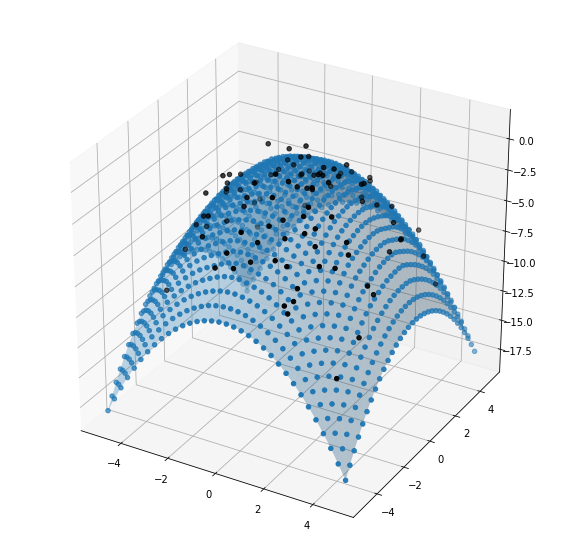

In [268]:
sd = np.sqrt(var)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# plot mean 
ax.plot_surface(xx,yy, -mu.reshape(34,34), label="mean and 2σ region",alpha=0.3)

# plot original data
ax.scatter(xx,yy,-mu)
ax.scatter(X_obs[:,0],X_obs[:,1],-Y_obs,color='black');